In [1]:
from datetime import timedelta

import numpy
import xarray

from matplotlib import pyplot

from tom.matplotlib import axes_iter

In [2]:
%config InlineBackend.figure_format = 'retina'

In [37]:
dataset = xarray.open_dataset('data/cat_tave_selectvars_500yrs.nc')

In [4]:
# Each timestep is one month.
print(numpy.unique(numpy.diff(dataset.T.values) / timedelta(days=1).total_seconds()))

[30.]


In [5]:
# Dataset is in order (T, Z [depth], Y [latitude], X [longitude])
ttave = dataset.Ttave.values
print(ttave.shape)

(6001, 42, 78, 11)


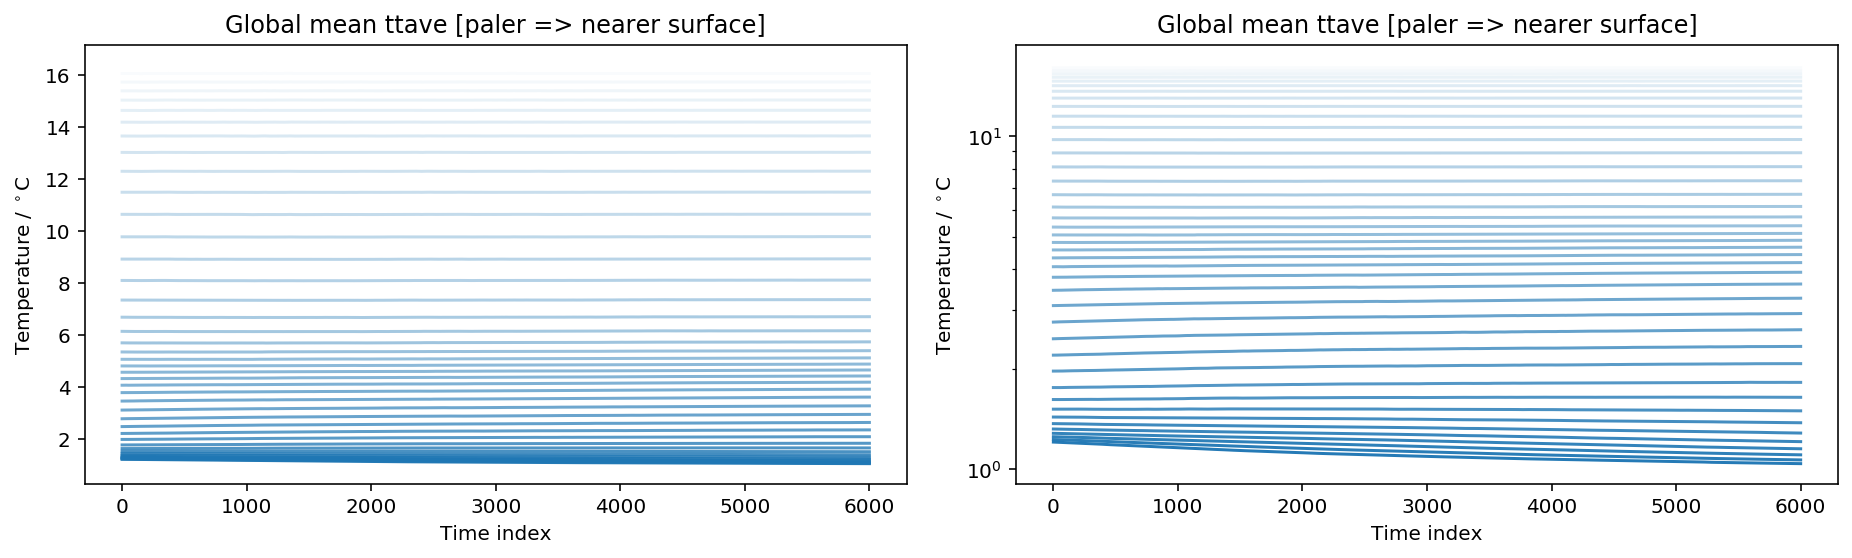

In [43]:
# Question - how does the temperature vary with height, roughly speaking?
# Interesting to see moderately rapid evolution over time, particularly at lower levels.

for use_log in axes_iter([False, True], ncols=2):
    average_ttave = numpy.mean(ttave, axis=(2, 3))  # Time, Z
    # pyplot.plot(average_ttave[:, -10], c='C0')  # GARBAGE - trying to inspect more detailed time variation.
    for i, moo in enumerate(average_ttave.T):
        pyplot.plot(moo, c='C0', alpha=i / average_ttave.shape[1])
    pyplot.title('Global mean ttave [paler => nearer surface]')
    if use_log:
        pyplot.yscale('log')
    pyplot.xlabel('Time index')
    pyplot.ylabel(r'Temperature / $^\circ\mathrm{C}$')

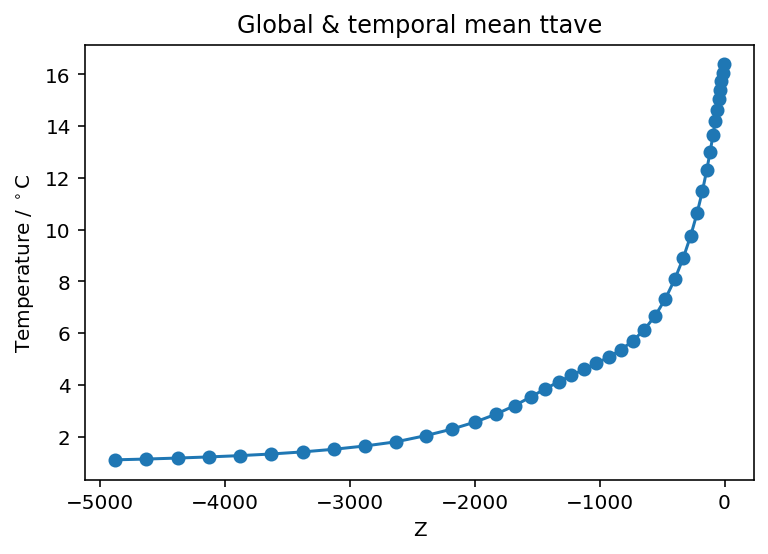

In [7]:
# Additionally average over all time for greater clarity.
average_ttave = numpy.mean(ttave, axis=(0, 2, 3))  # Z
pyplot.plot(dataset.Z.values, average_ttave, marker='o')
pyplot.title('Global & temporal mean ttave')
pyplot.xlabel('Z')
pyplot.ylabel(r'Temperature / $^\circ\mathrm{C}$')
pyplot.show()

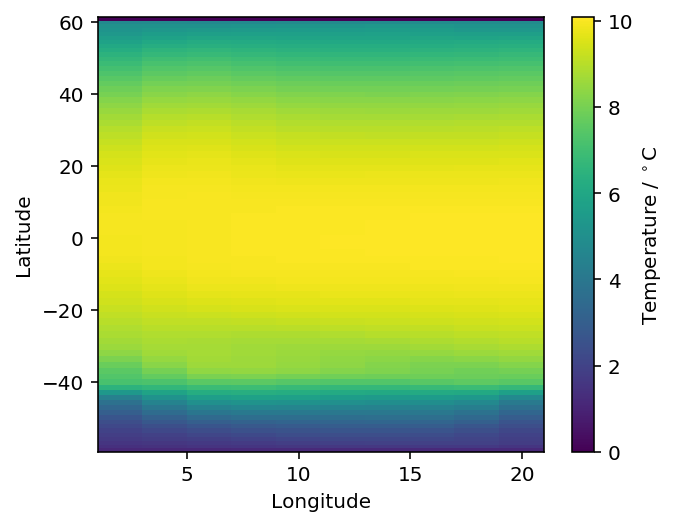

In [49]:
# Question - how does temperature vary over latitude & longitude?
pyplot.figure(figsize=(5, 4))
pyplot.pcolormesh(dataset.X.values, dataset.Y.values, numpy.mean(dataset.Ttave.values, axis=(0, 1)))
pyplot.xlabel('Longitude')
pyplot.ylabel('Latitude')
colorbar = pyplot.colorbar()
colorbar.set_label(r'Temperature / $^\circ\mathrm{C}$')
pyplot.show()

In [50]:
def plot_all_ttaves(i_t, dataset: xarray.Dataset):
    """Plot the average temperate (Ttave) at all heights, latitudes & longitudes.
    
    :param i_t: The index of the reference time.
    :param dataset: The full xarray dataset.
    """
    ttave = dataset['Ttave'].values
    for i_z, z in axes_iter(enumerate(dataset.Z.values), ncols=6, row_height=3, sharey=True, shared_ylabel='Latitude',
                        clim_convex_hull=True):
        temp = ttave[i_t, i_z]
        vmin = numpy.min(temp)
        vmax = numpy.max(temp)

        pyplot.title(f'{z:.2f}m')
        pyplot.pcolormesh(dataset.X.values, dataset.Y.values, temp, vmin=vmin, vmax=vmax)
    
    # Slightly hacky... only show these axes labels in the final plot.
    pyplot.xlabel('Longitude')
    colorbar = pyplot.colorbar()
    colorbar.set_label(r'Temperature / $^\circ\mathrm{C}$')

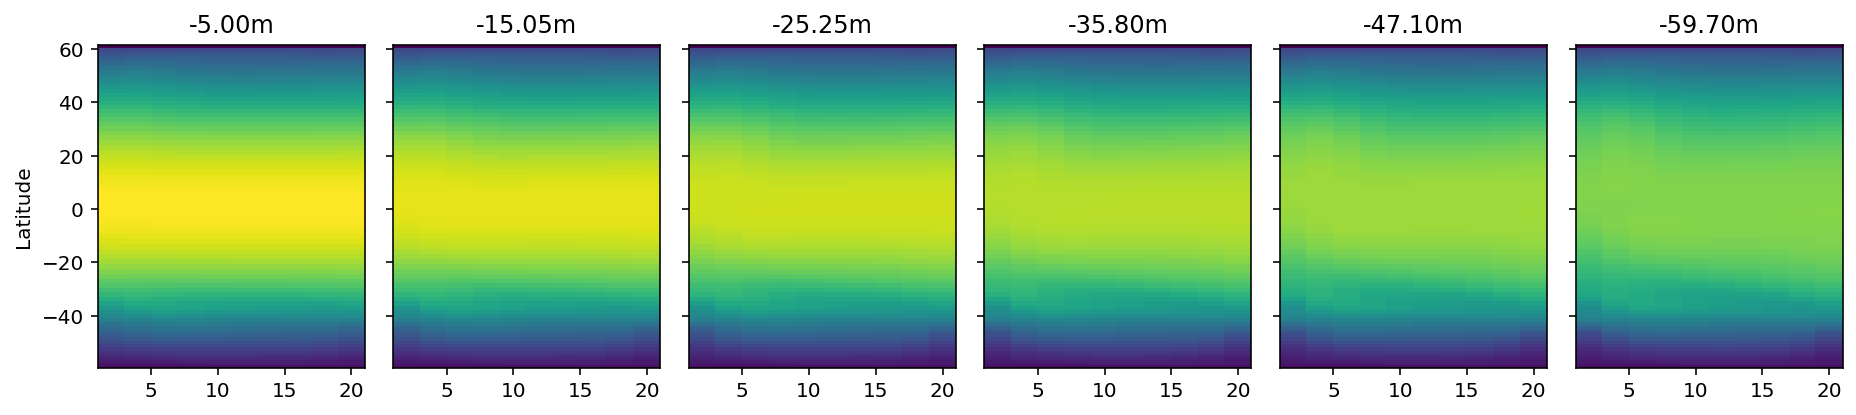

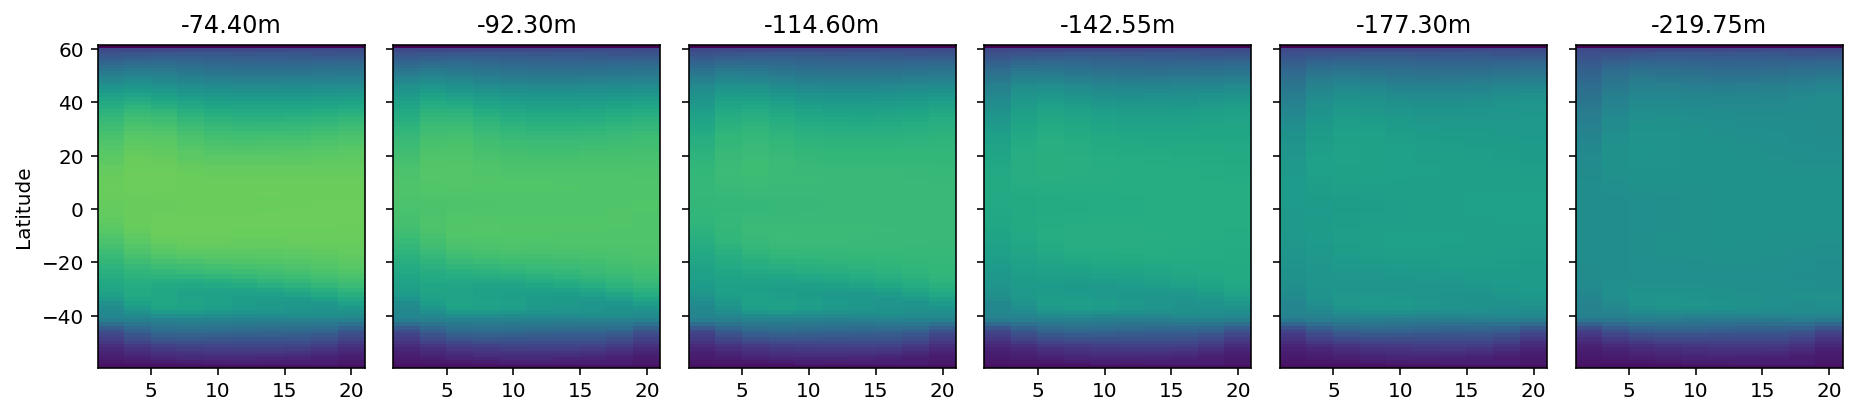

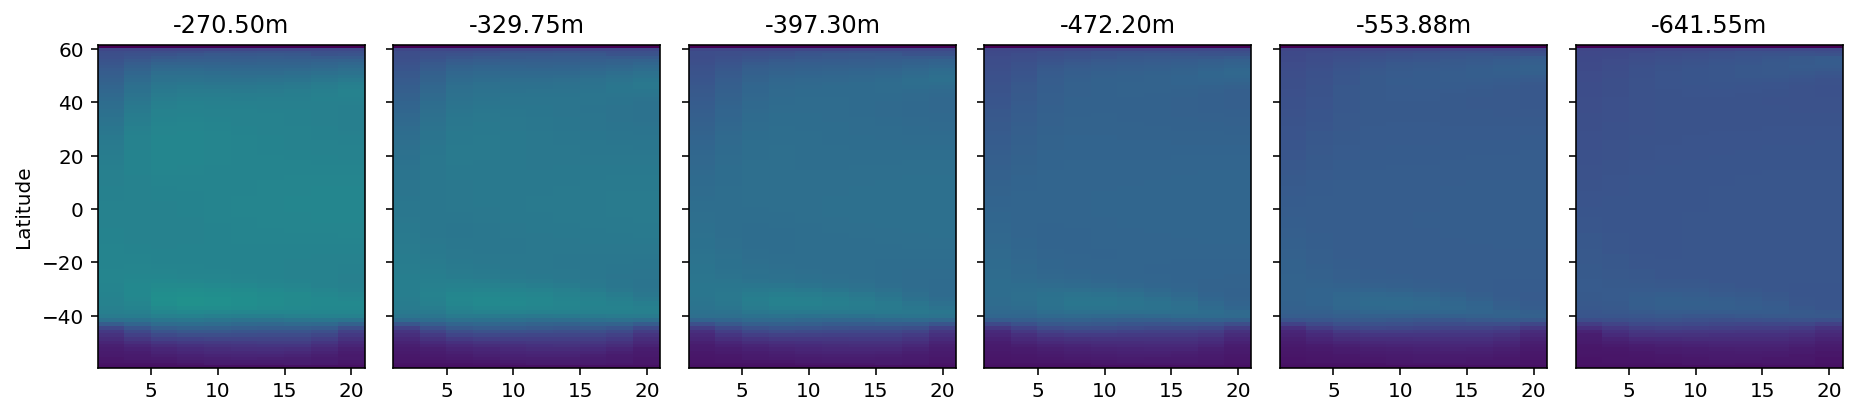

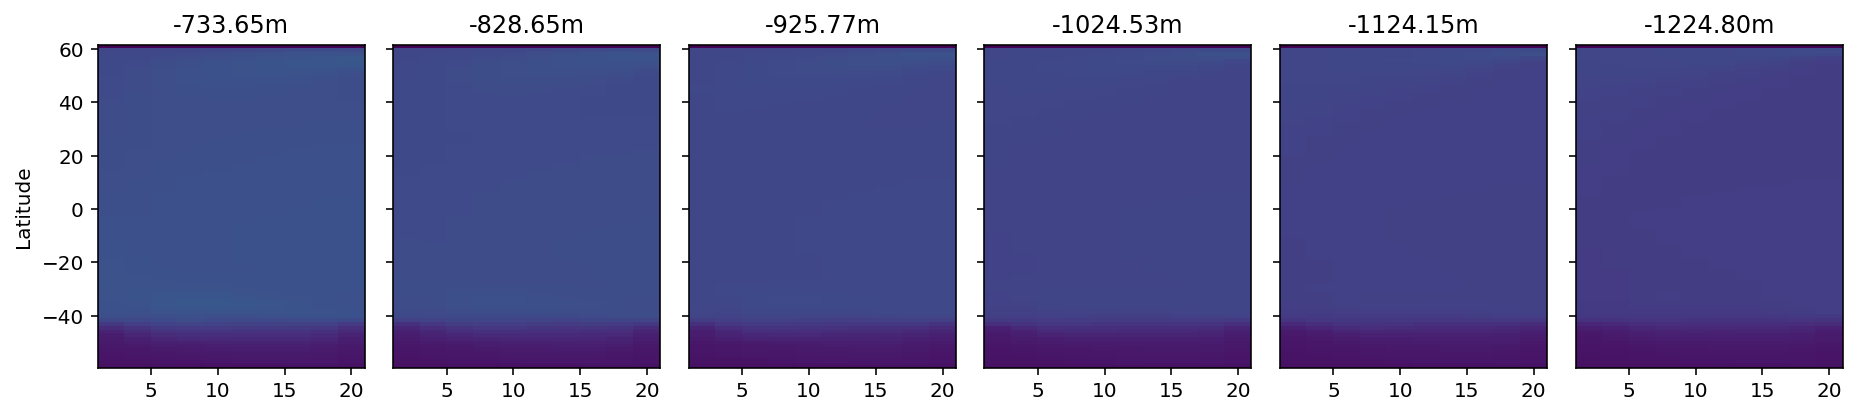

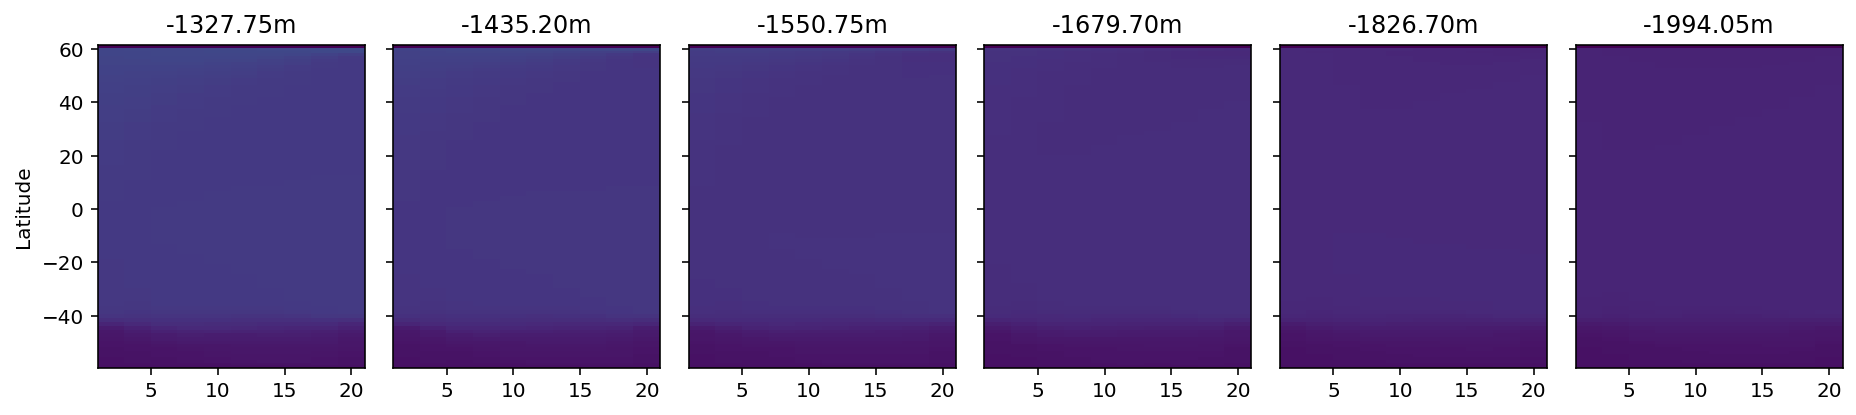

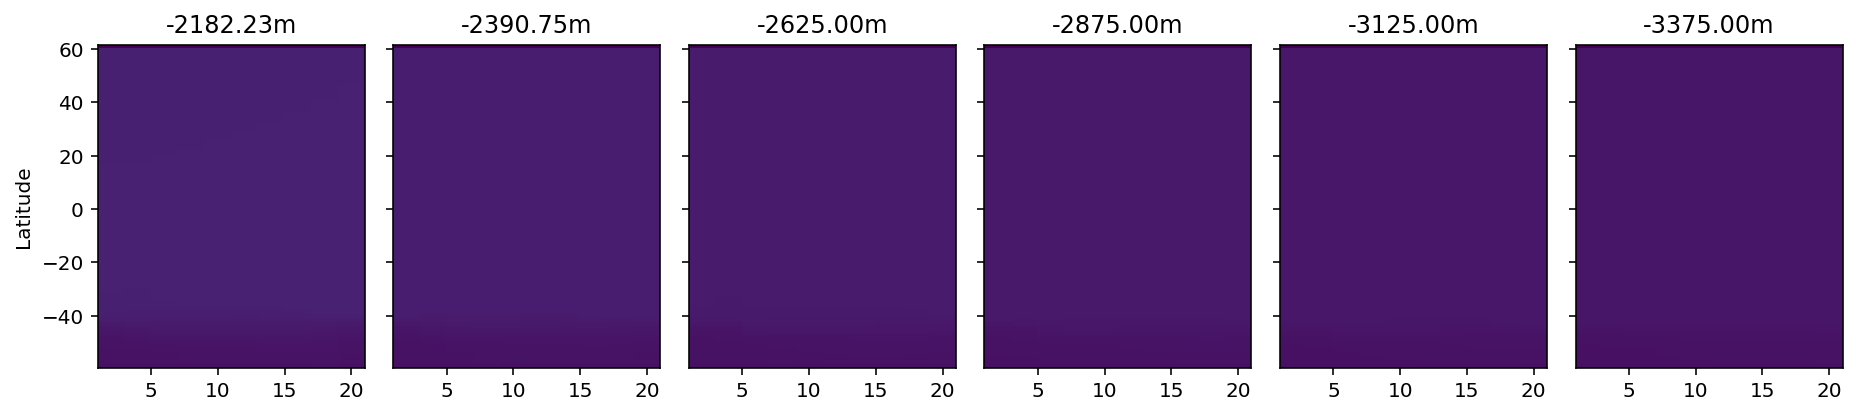

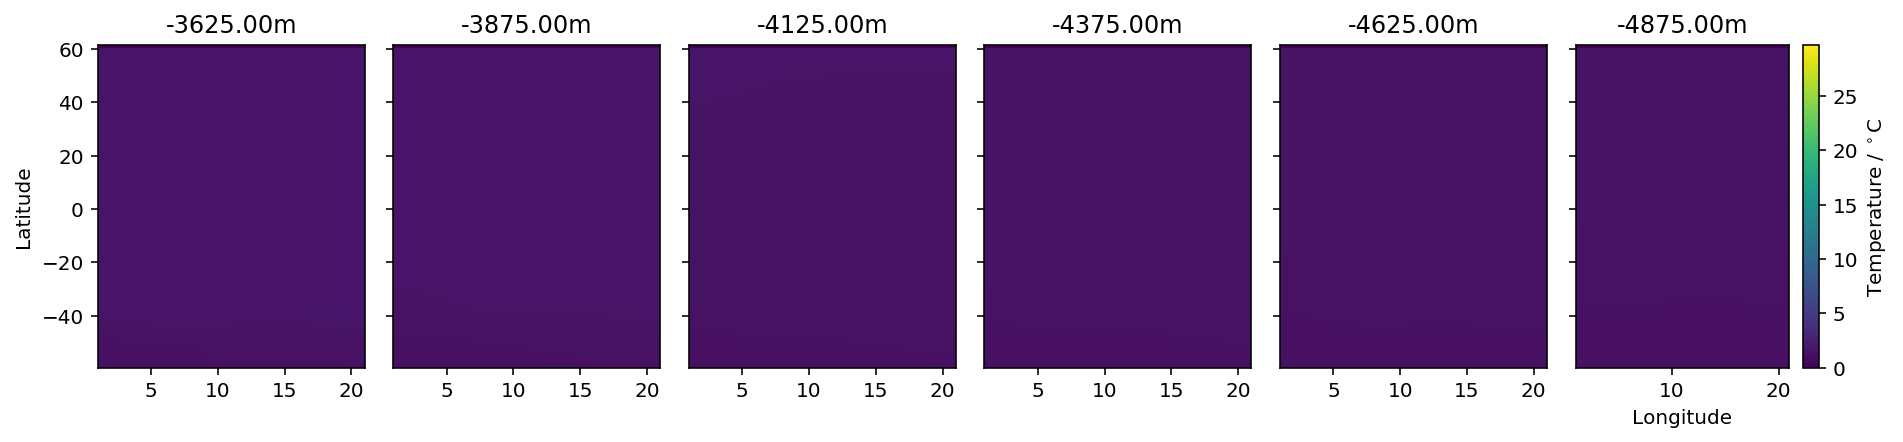

In [51]:
plot_all_ttaves(0, dataset)

In [52]:
def plot_all_differences(i_t0: int, i_t1: int, dataset: xarray.Dataset):
    """Plot the differences at all heights, latitudes & longitudes.
    
    :param i_t0: The index of the first reference time.
    :param i_t1: The index of the second reference time.
    :param dataset: The full xarray dataset.
    """
    ttave = dataset['Ttave'].values
    for i_z, z in axes_iter(enumerate(dataset.Z.values), ncols=6, row_height=3, sharey=True, shared_ylabel='Latitude',
                        clim_convex_hull=True):
        diff = ttave[i_t1, i_z] - ttave[i_t0, i_z]
        vlim = numpy.max(abs(diff))

        pyplot.title(f'{z:.2f}m')
        pyplot.pcolormesh(dataset.X.values, dataset.Y.values, diff, cmap='bwr', vmin=-vlim, vmax=vlim)
    
    # Slightly hacky... only show these axes labels in the final plot.
    pyplot.xlabel('Longitude')
    colorbar = pyplot.colorbar()
    colorbar.set_label(r'Temperature / $^\circ\mathrm{C}$')

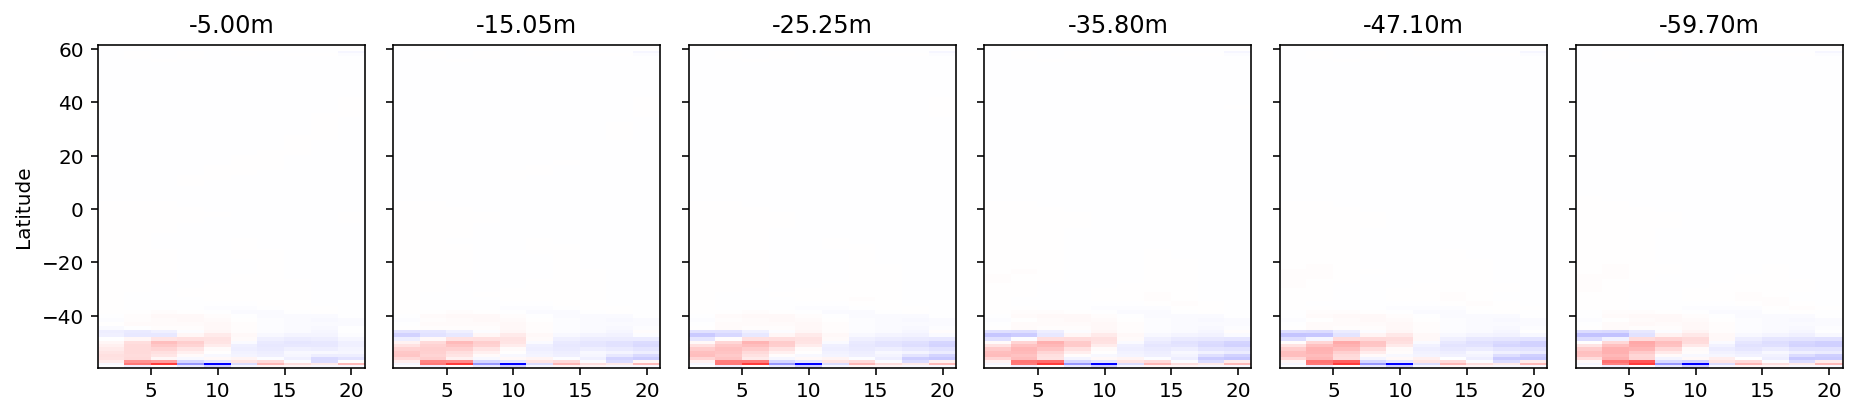

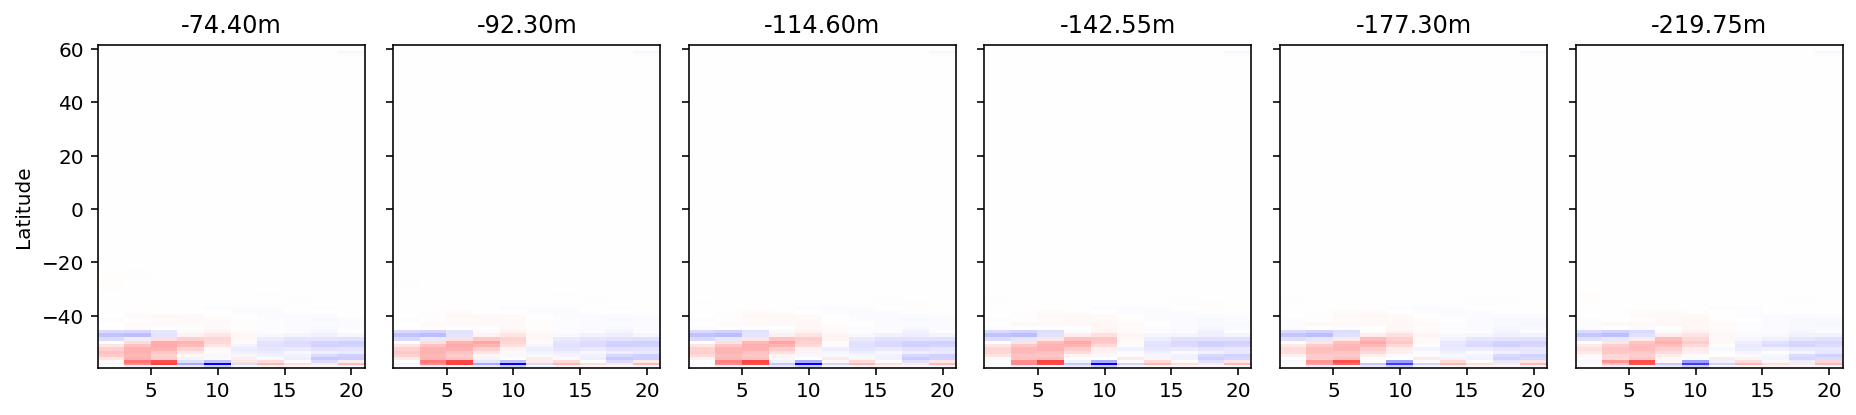

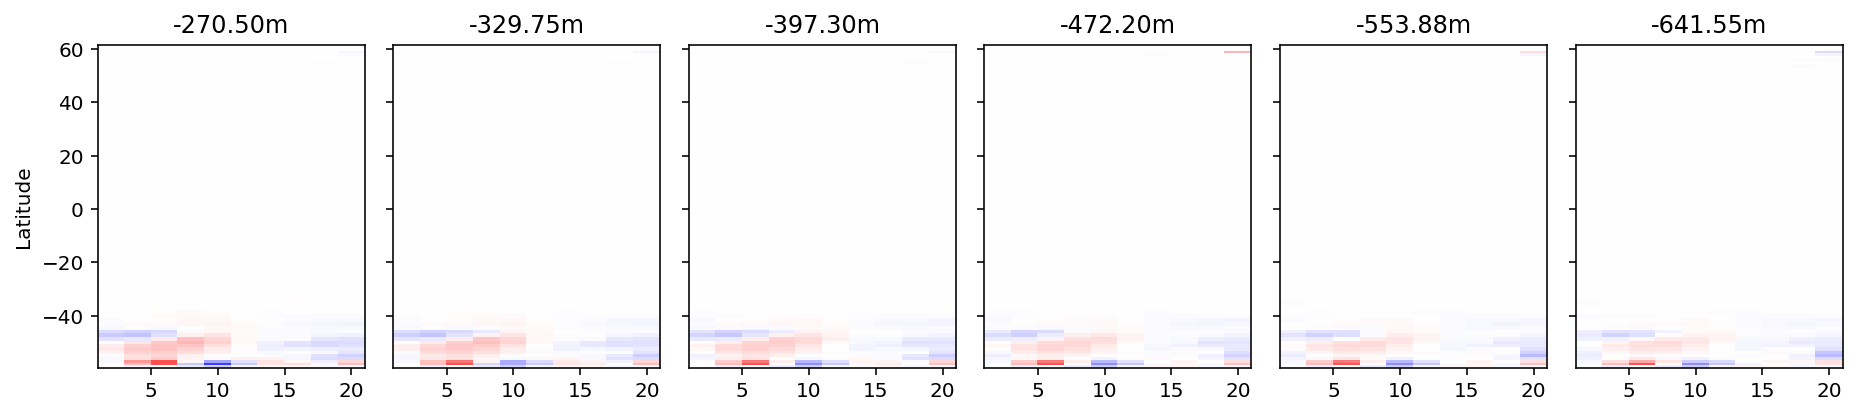

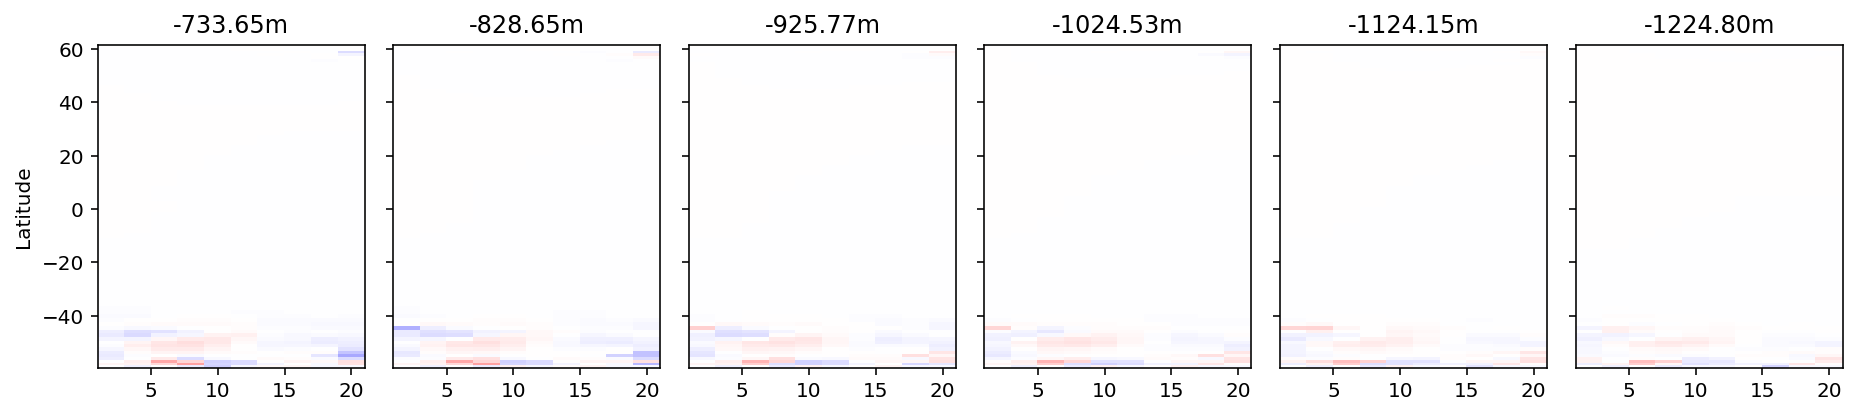

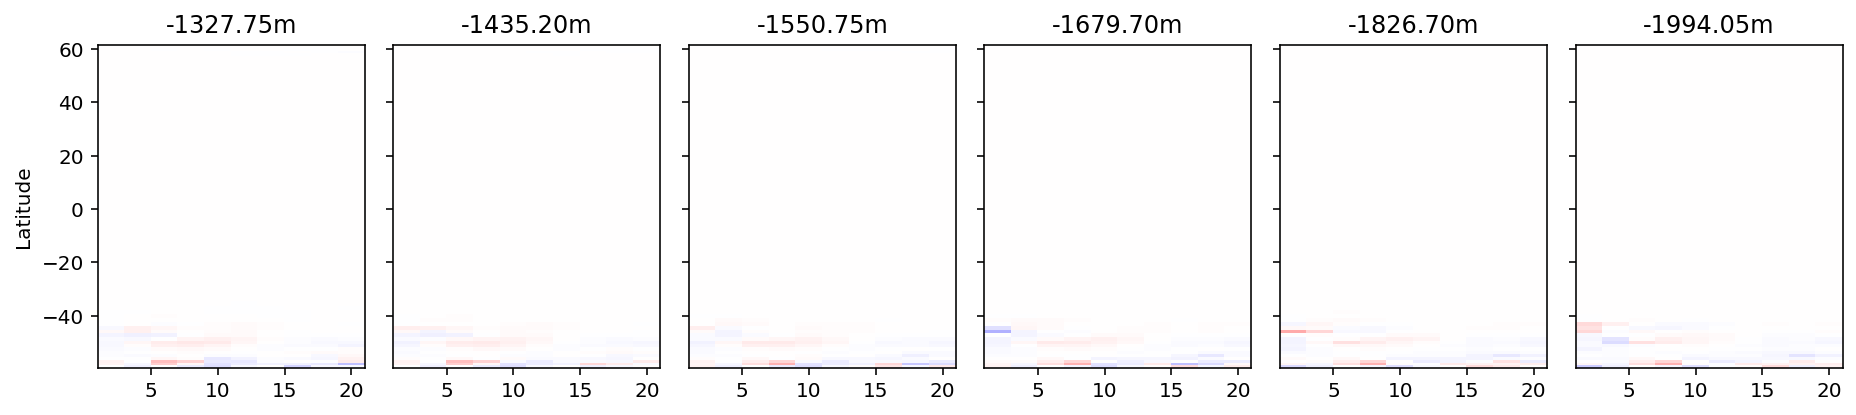

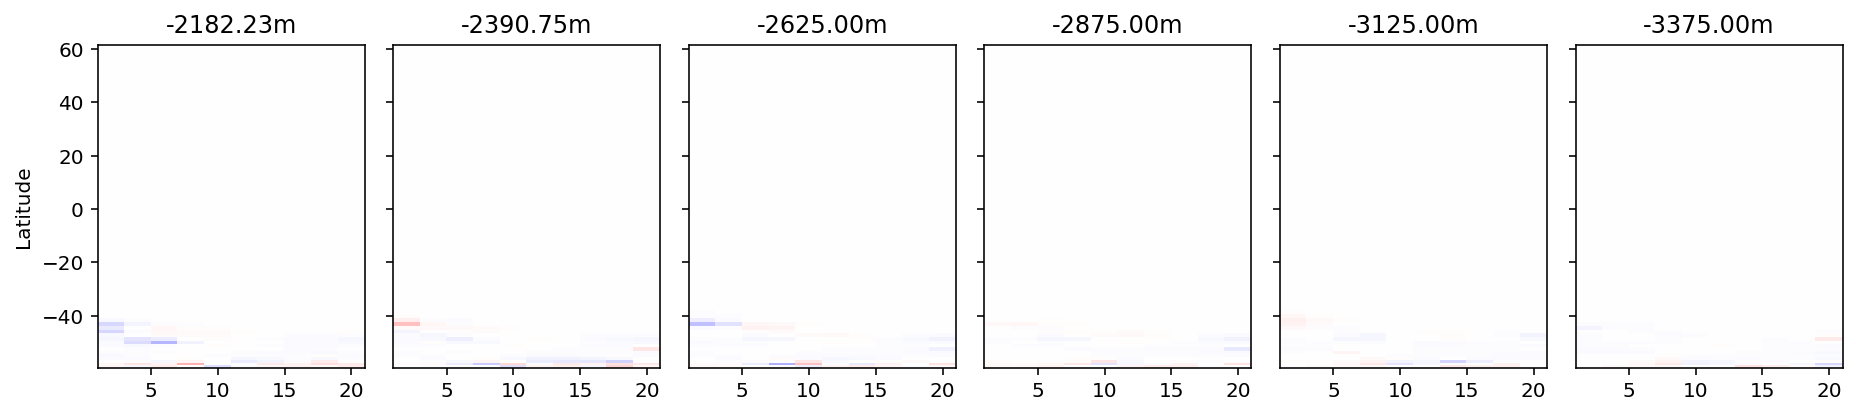

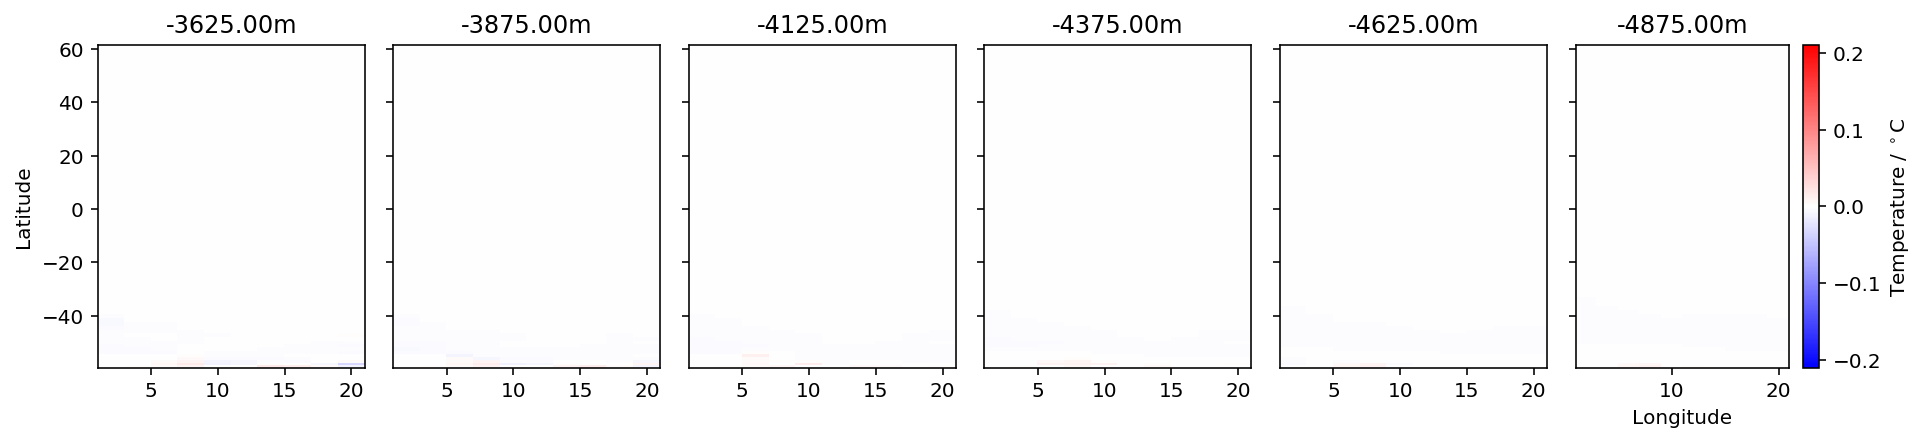

In [53]:
plot_all_differences(0, 10, dataset)

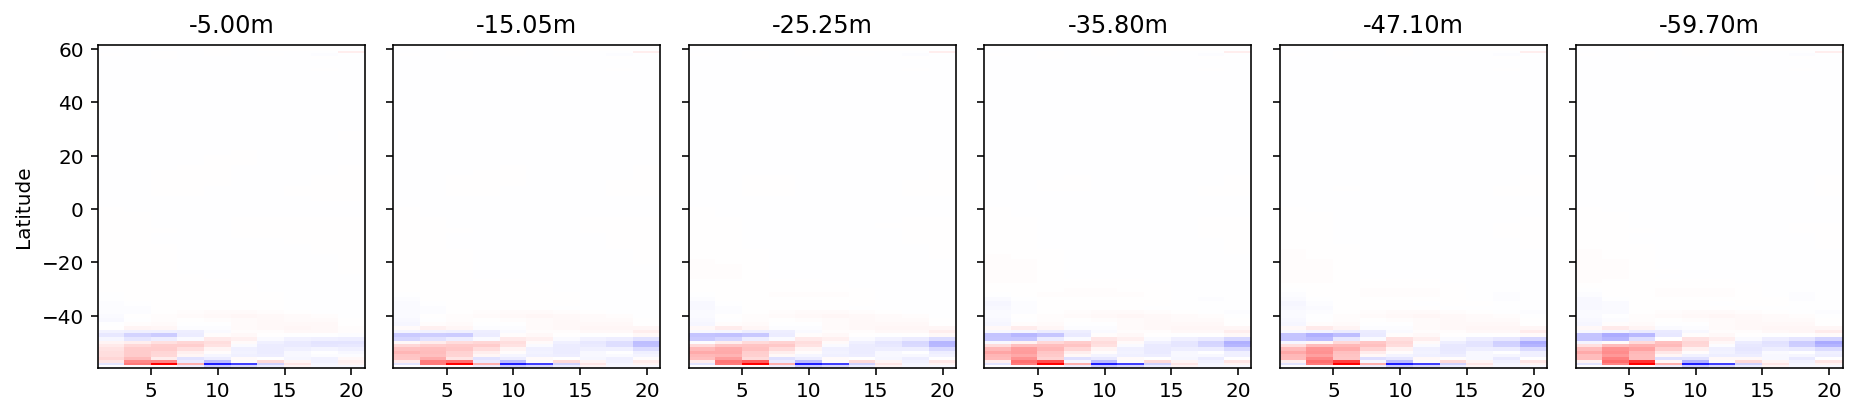

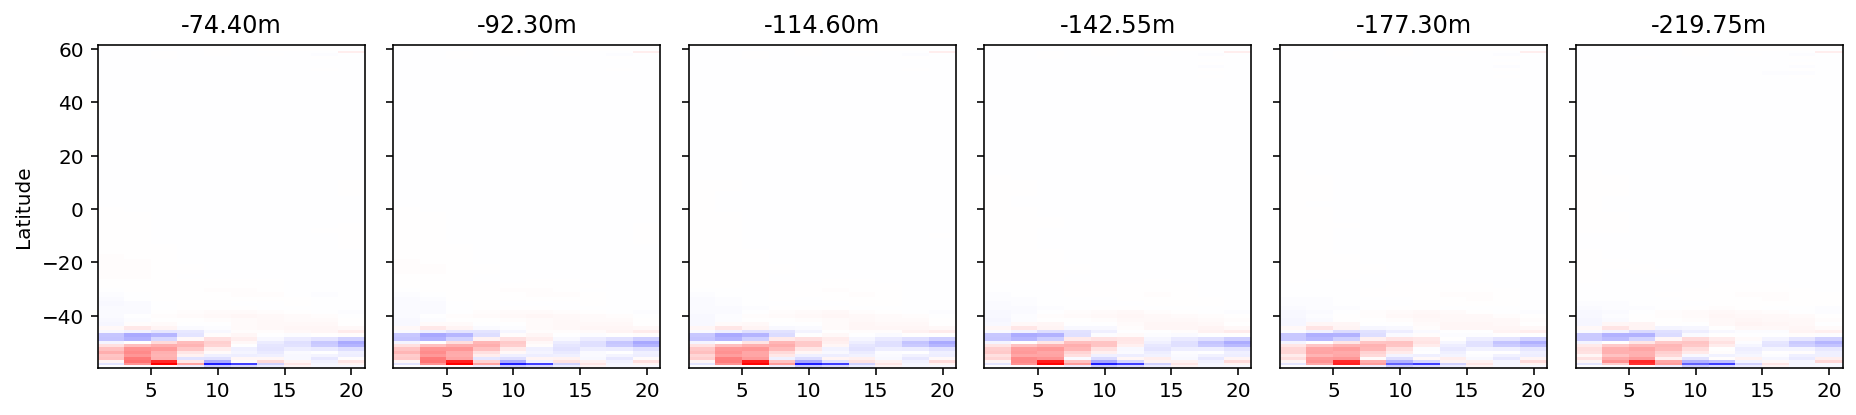

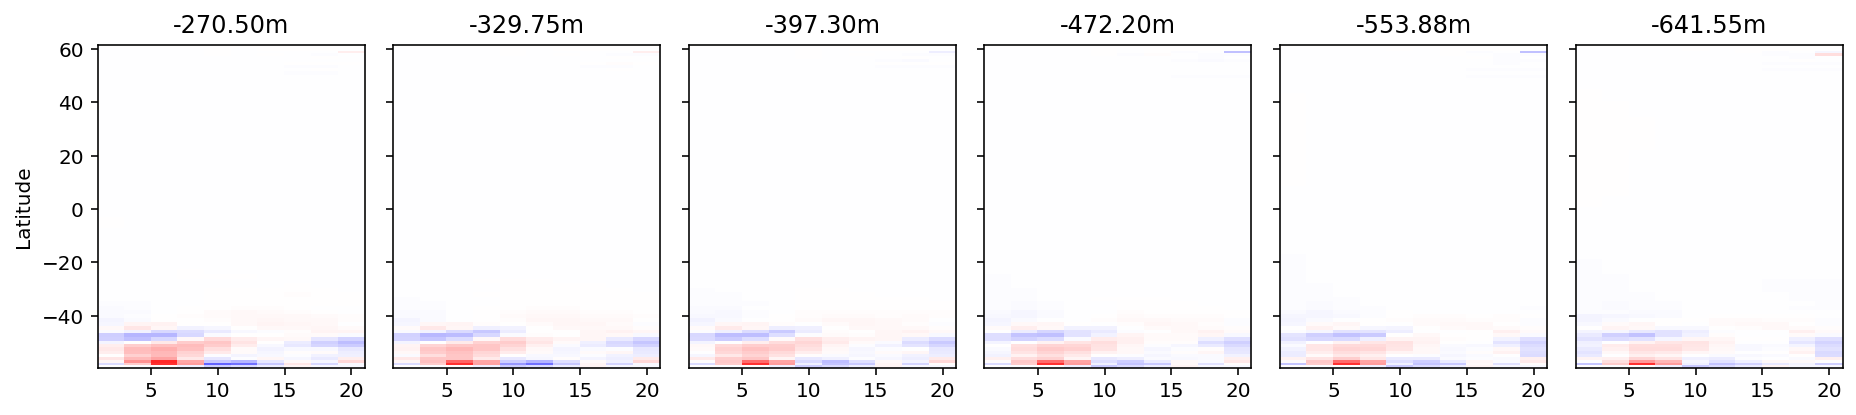

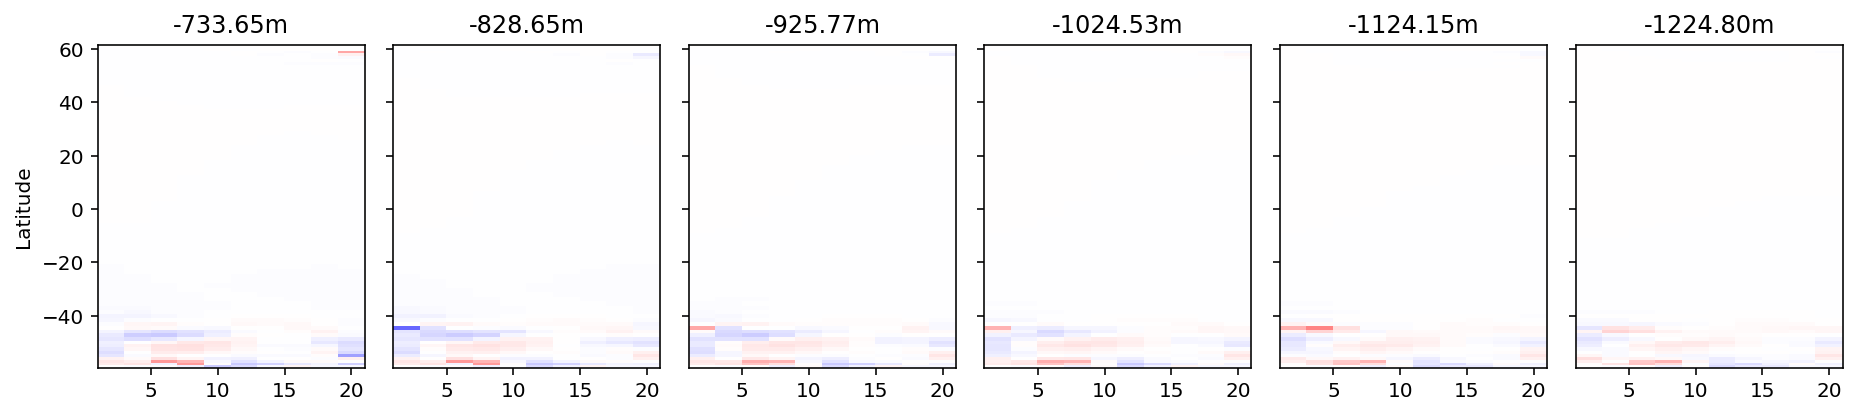

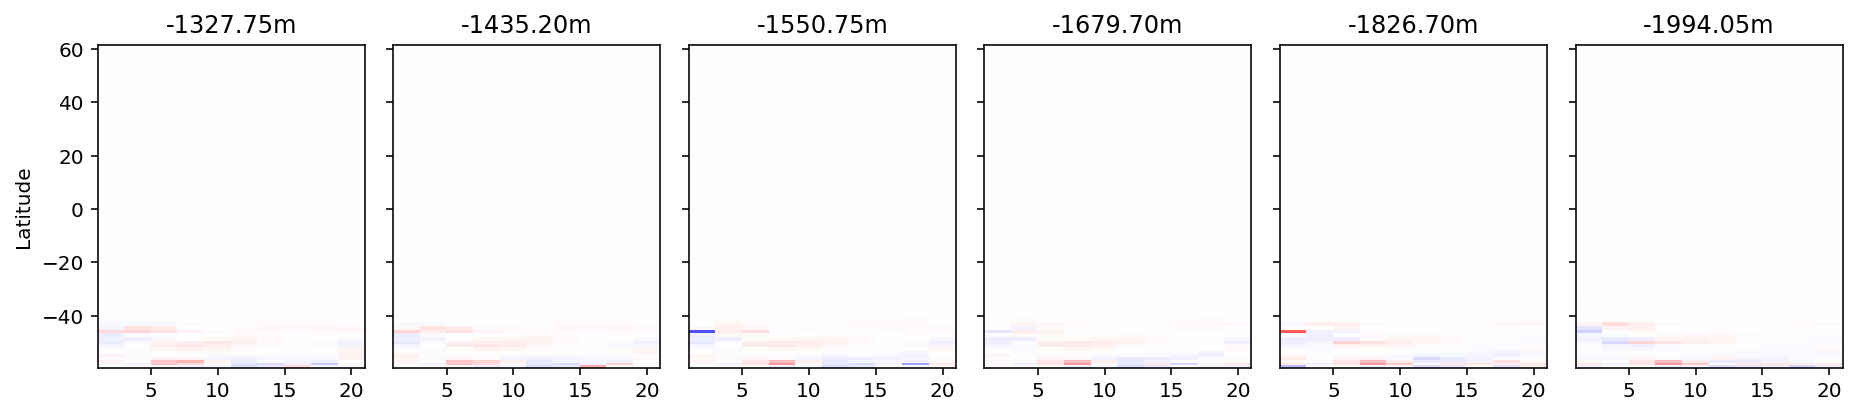

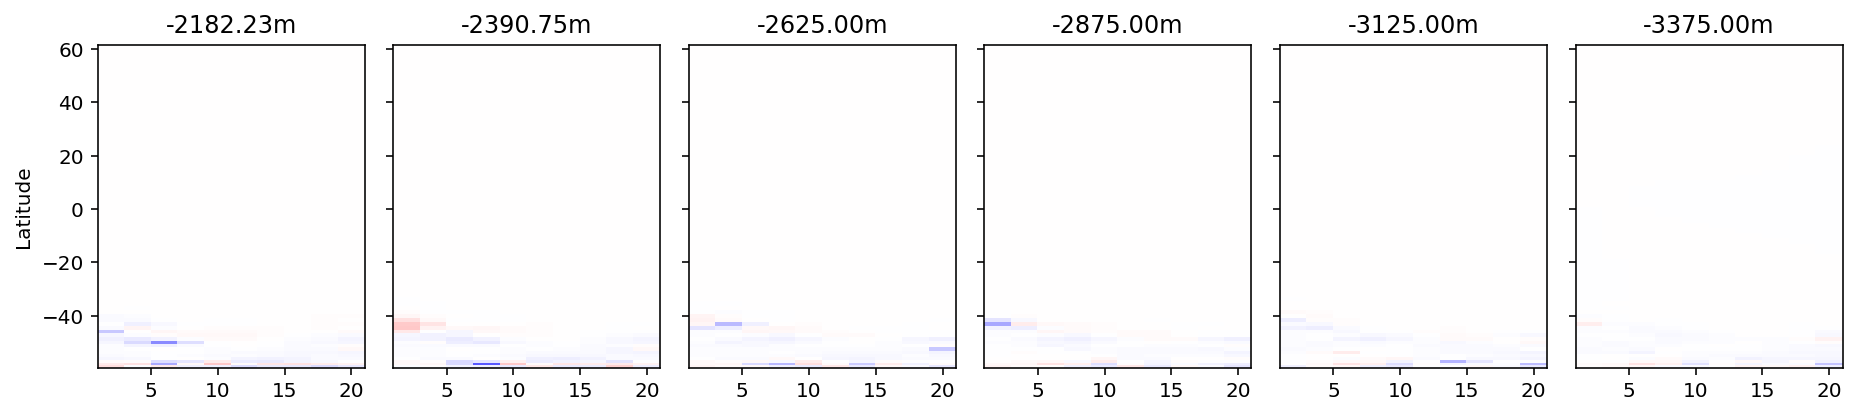

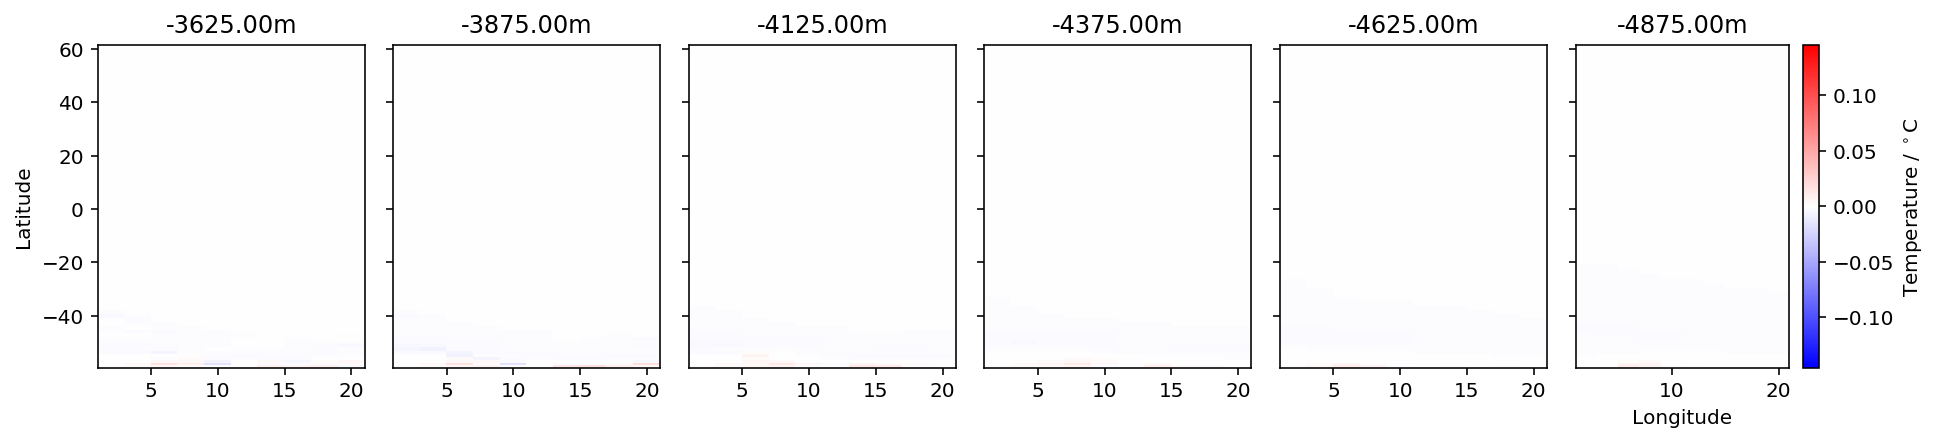

In [54]:
plot_all_differences(5, 15, dataset)

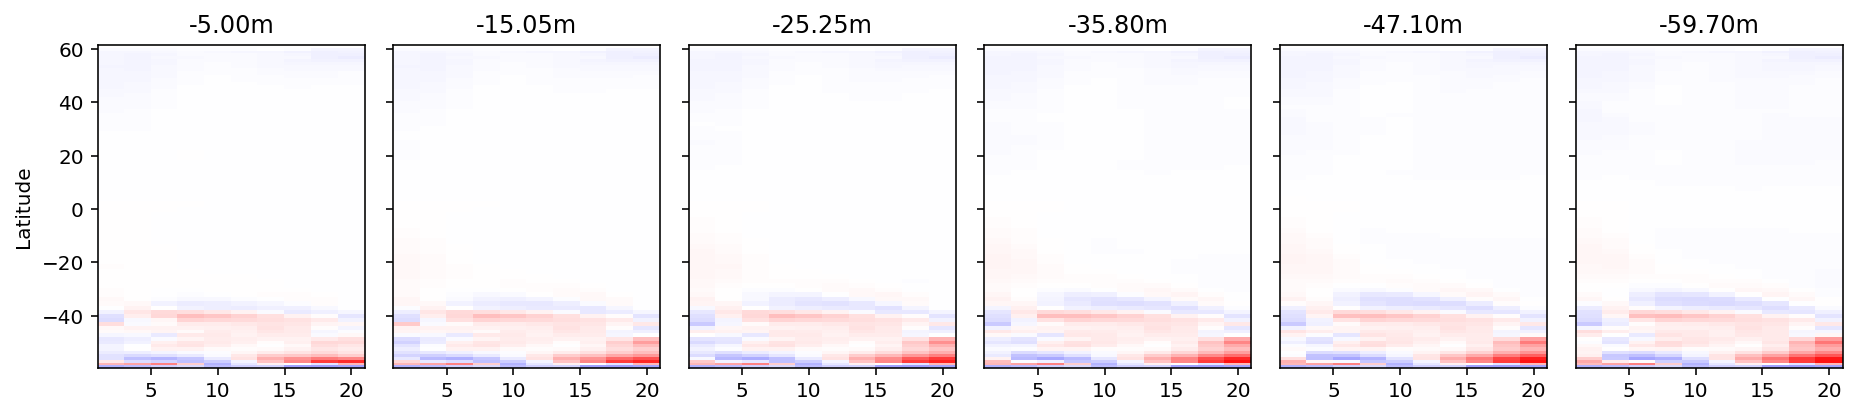

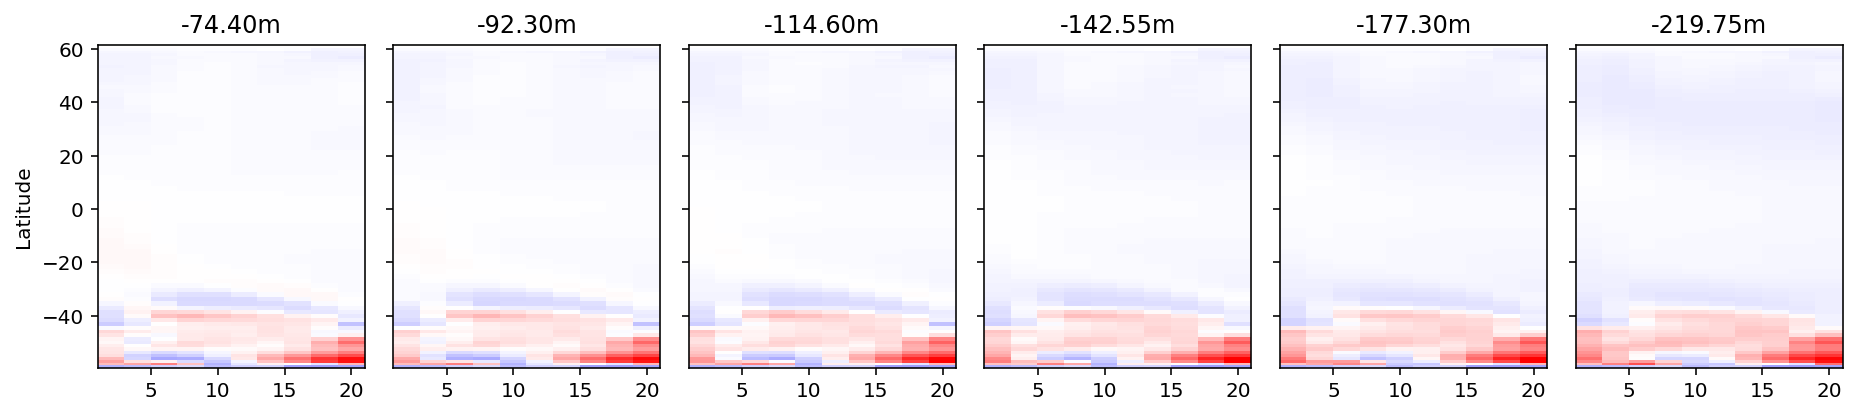

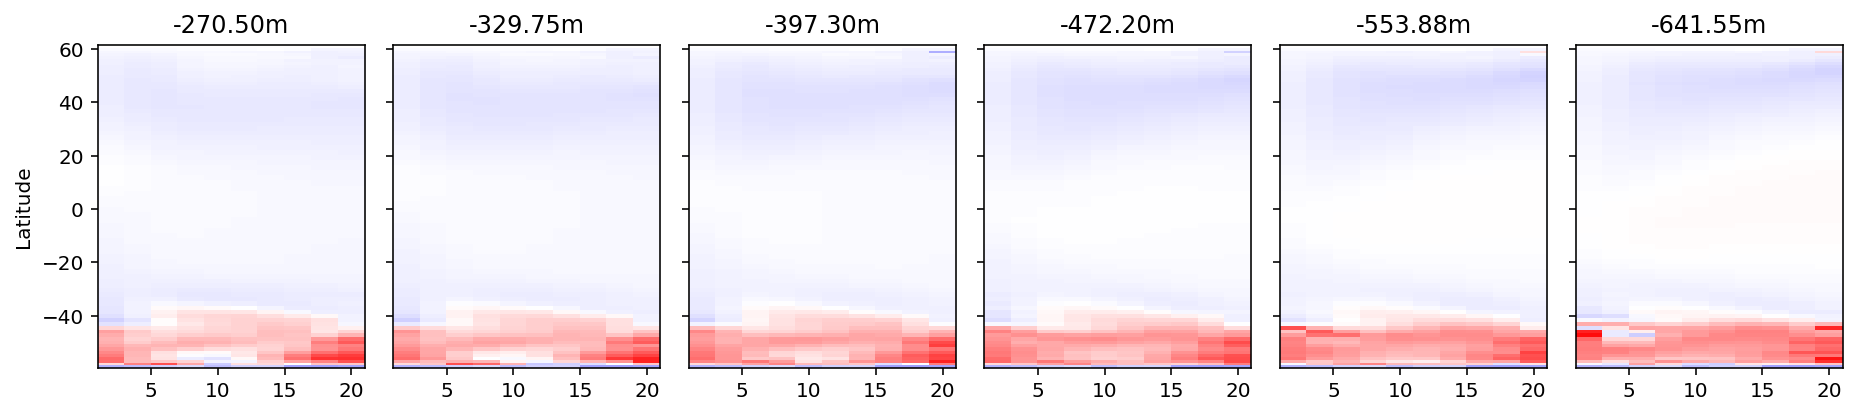

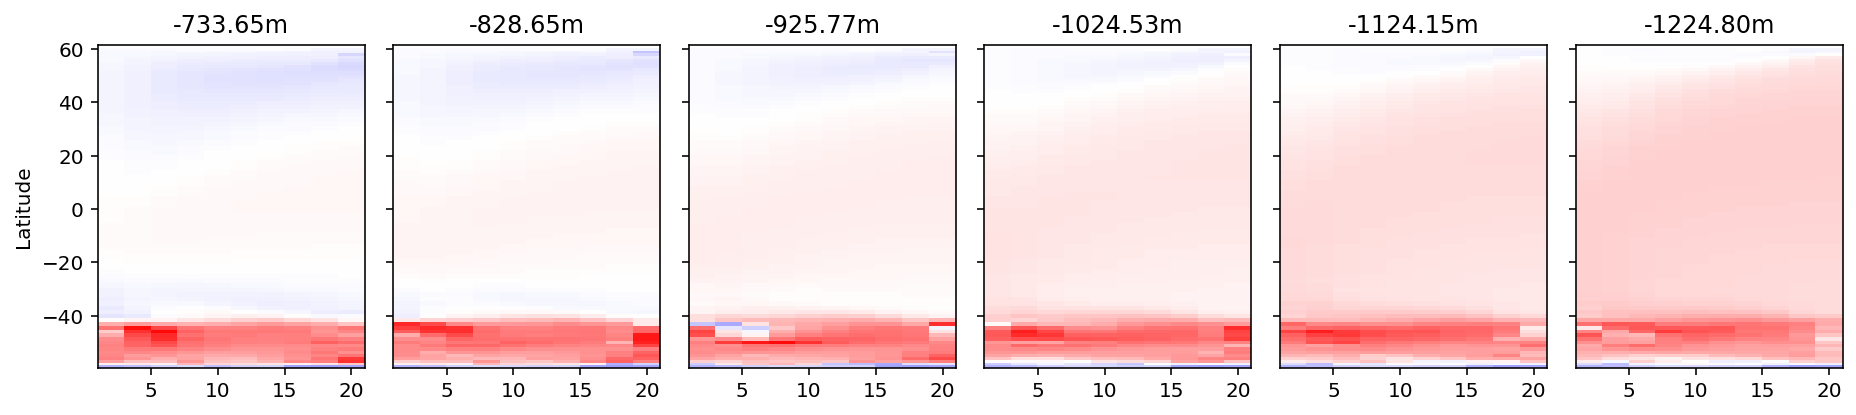

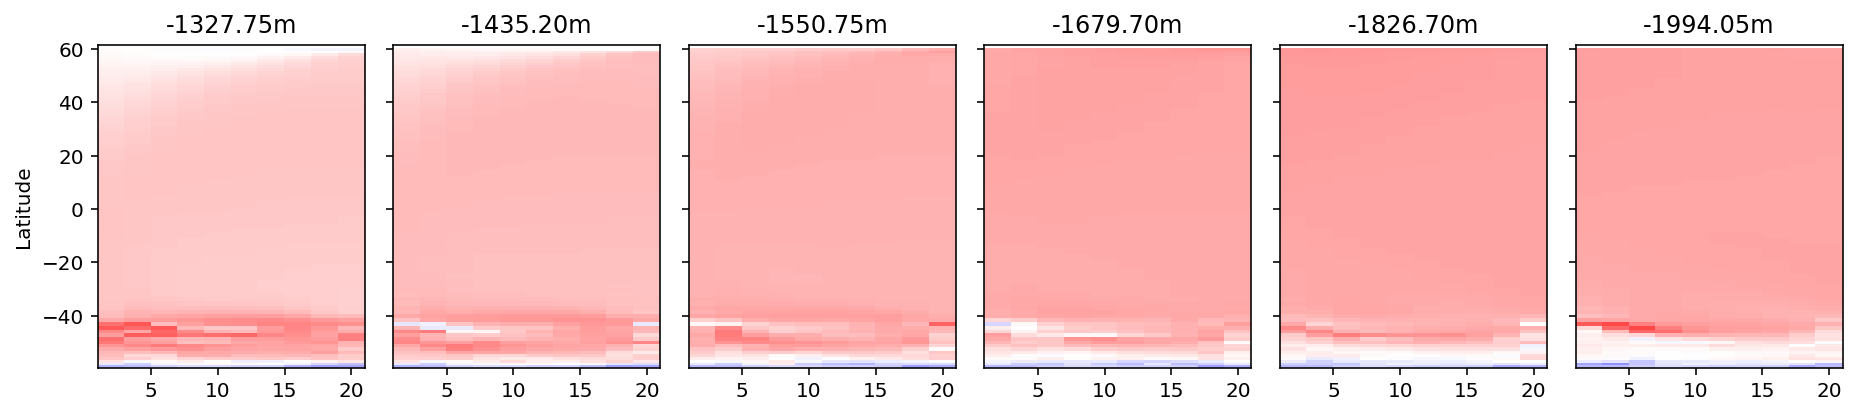

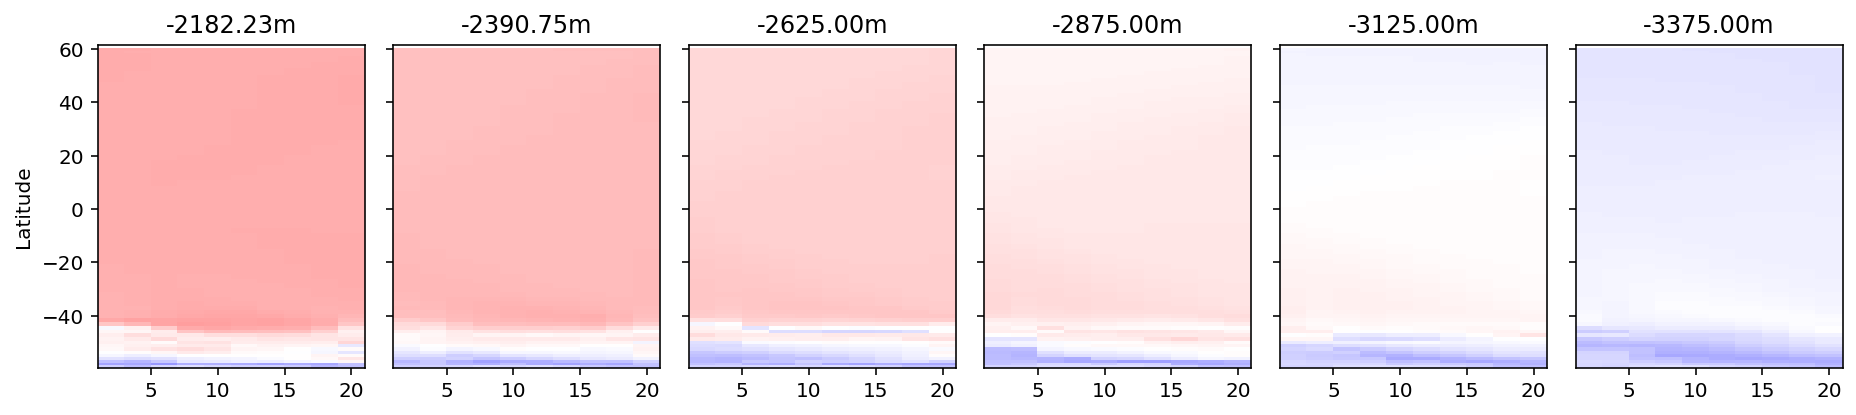

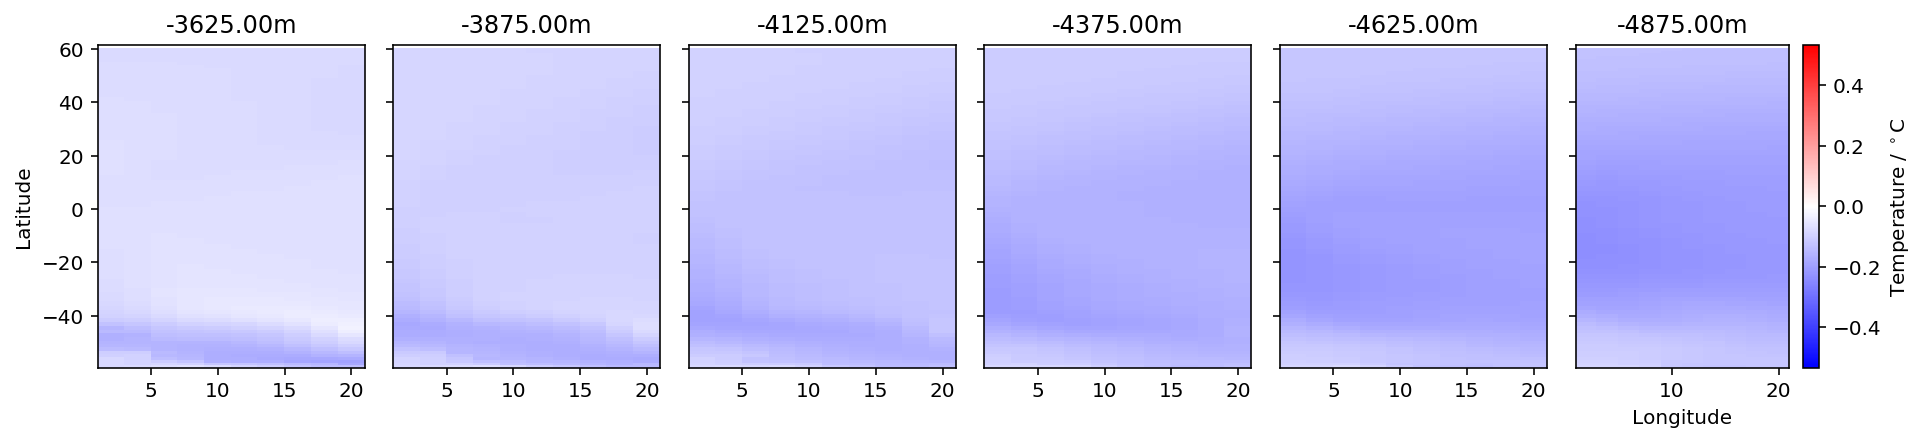

In [55]:
plot_all_differences(0, 5000, dataset)

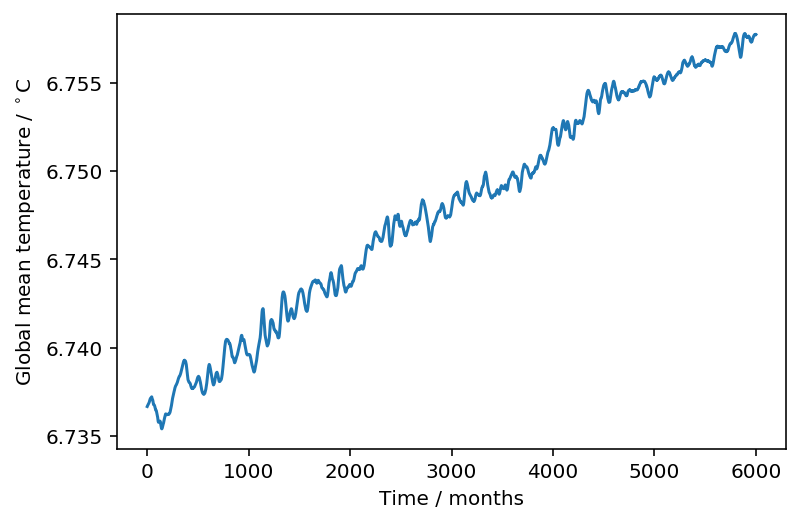

In [11]:
# Do we have any basic conservation properties? Global mean temperature appears to not
# be conserved. Presumably this stems from something important?
pyplot.plot(numpy.mean(ttave, axis=(1, 2, 3)))
pyplot.xlabel('Time / months')
pyplot.ylabel(r'Global mean temperature / $^\circ\mathrm{C}$')
pyplot.show()